In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)

## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [4]:
images = Path("data/South-Building/images/")

outputs = Path("outputs/sfm/")
sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [5]:
if not images.exists():
    !wget https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip -P data/
    !unzip -q data/South-Building.zip -d data/

--2024-02-07 12:31:25--  https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip
Resolving cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)... 129.132.114.72
Connecting to cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)|129.132.114.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230948942 (220M) [application/zip]
Saving to: 'data/South-Building.zip.1'

South-Building.zip. 100%[===================>] 220.25M  42.3MB/s    in 6.0s    

2024-02-07 12:31:31 (36.9 MB/s) - 'data/South-Building.zip.1' saved [230948942/230948942]



## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [6]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2024/02/07 12:32:35 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/02/07 12:32:35 hloc INFO] Found 128 images in root data/South-Building/images.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 529M/529M [00:11<00:00, 49.0MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:12<00:00, 10.38it/s]
[2024/02/07 12:33:03 hloc INFO] Finished exporting features.
[2024/02/07 12:33:03 hloc INFO] Extracting image pairs from a retrieval database.
[2024/02/07 12:33:04 hlo

## Extract and match local features

In [7]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/02/07 12:33:16 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/02/07 12:33:16 hloc INFO] Found 128 images in root data/South-Building/images.


Loaded SuperPoint model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 33.12it/s]
[2024/02/07 12:33:20 hloc INFO] Finished exporting features.
[2024/02/07 12:33:20 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:37<00:00, 10.67it/s]
[2024/02/07 12:33:58 hloc INFO] Finished exporting matches.


## 3D reconstruction
Run COLMAP on the features and matches.

In [8]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2024/02/07 12:34:03 hloc INFO] Creating an empty database...
[2024/02/07 12:34:03 hloc INFO] Importing images into the database...
[2024/02/07 12:34:08 hloc INFO] Importing features into the database...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1966.20it/s]
[2024/02/07 12:34:08 hloc INFO] Importing matches into the database...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 640/640 [00:00<00:00, 2873.60it/s]
[2024/02/07 12:34:08 hloc INFO] Performing geometric verification of the matches...
I20240207 12:34:08.546305 59336 misc.cc:198] 
Custom feature matching
I202402

## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

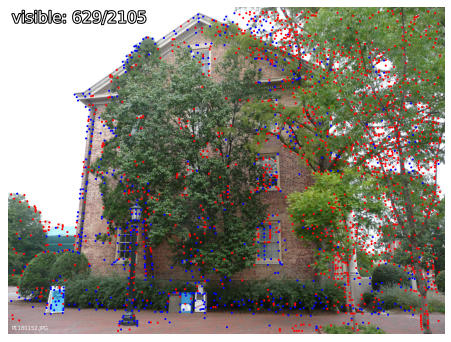

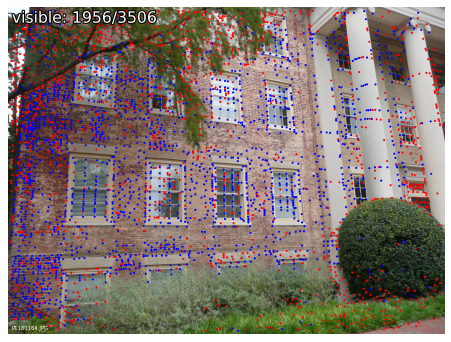

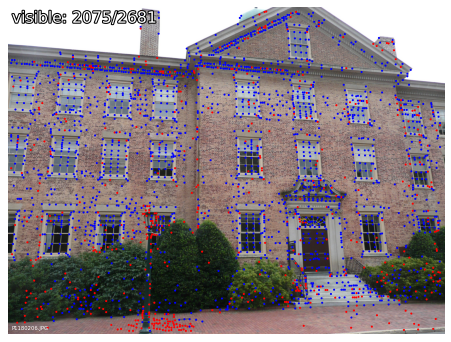

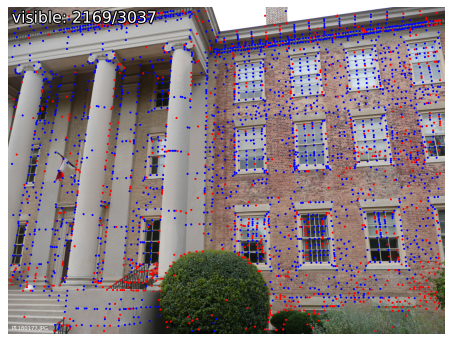

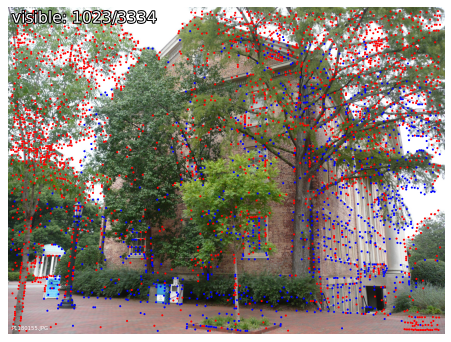

In [9]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

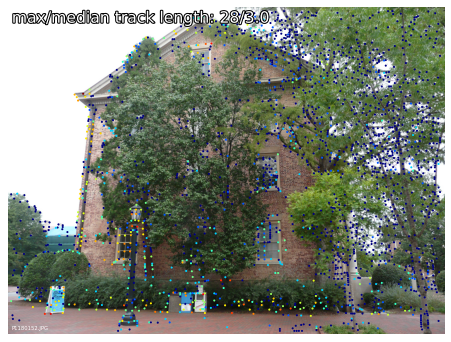

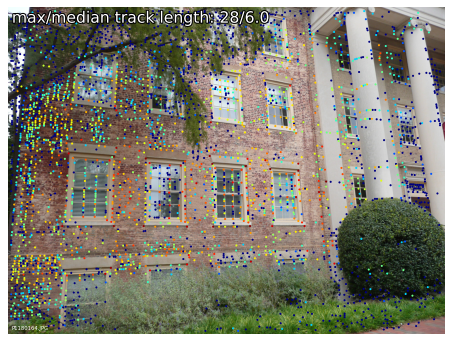

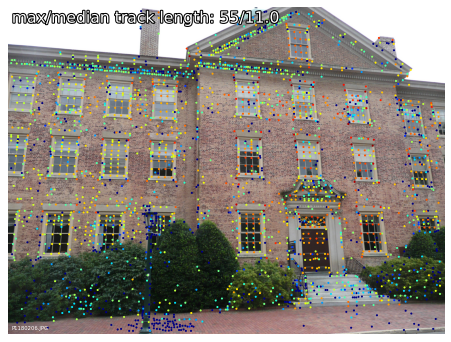

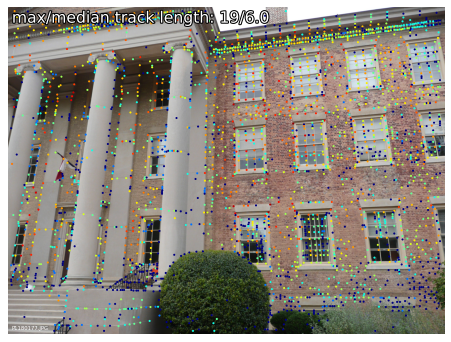

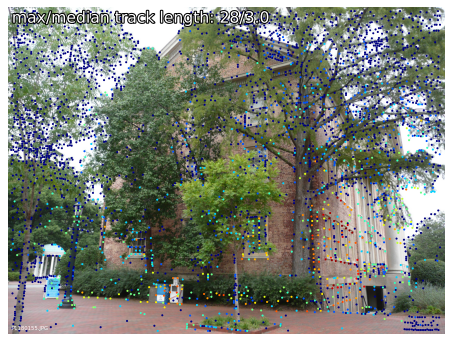

In [10]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

In [11]:
visualization.visualize_sfm_2d(model, images, color_by="depth", n=5)

AttributeError: 'pycolmap.Image' object has no attribute 'transform_to_image'